## packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

### Read grid and masks

In [2]:
# define basin we want
iB = 6   # see mskBasin if you want for later; maybe we should write this to file

In [3]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"

In [4]:
bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

In [5]:
# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Salt'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0,
    'seaice_variable_salinity_flag': 0
}

deltaTime = myparms['timeStep']
dt = 86400

In [6]:
# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

In [7]:
# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

(50,) (50, 1350, 270)


In [8]:
#mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

hf1 (1350, 270)


In [9]:
# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))
mskBasin3D.shape

(50, 1350, 270)

### Get timesteps

In [10]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
times["2014"] = np.arange(3,5,1)
# times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

### salt tendency

In [11]:
# ocean and ice
AB_gT=0
AB_gS=0
debug = False

In [12]:
# ffac = 1e-6
ffac = 1

In [13]:
dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()

In [14]:
# read thetadr
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])


SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisSALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisSALTDR = thisSALTDR.reshape(nz,ny,nx)
    SALTDR[i] = thisSALTDR

SALTDR =  (SALTDR[1, :, :,:] - SALTDR[0, :,:, :]) / dt    # PSU.m/s

In [15]:
tmptend = myparms['rhoconst'] * (SALTDR - AB_gS) * mk3D_mod(RAC,SALTDR)    # kg/m^3 * PSU.m/s * m^2 = g/s
budgO = {}
budgO['fluxes'] = {}
budgI = {}
budgI['fluxes'] = {}
budgOI = {}

# ocean

budgO['fluxes']['tend'] = tmptend
budgO['tend'] = np.nansum(tmptend,axis=0)

# # ice
# if myparms['seaice_variable_salinity_flag'] == 0:
#     budgI['tend'] = myparms['SIsal0'] * SIheff * myparms['rhoi'] * RAC
# else:
#     budgI['tend'] = 0 * SIheff * myparms['rhoi'] * RAC

# # ocean and ice
# budgOI['tend'] = budgO['tend'] + budgI['tend']

### Calculate horizontal convergence
We used to do this with calc_UV_conv_1face but now we just want totally the calc_UV

In [16]:
# read adv and dfe
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

tmpUo = myparms['rhoconst'] * (ADVx_SLT + DFxE_SLT)
tmpVo = myparms['rhoconst'] * (ADVy_SLT + DFyE_SLT)

# reshape and get the faces
tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['fluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['hconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo,axis=0),np.nansum(tmpVo,axis=0))

In [17]:
# also do hconv for ADV and DF
tmpUo = get_aste_faces(ADVx_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['fluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

tmpUo = get_aste_faces(DFxE_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['fluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

In [18]:
# read the vars
file_name = "budg2d_hflux_set1"
meta_budg2d_hflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_hflux_set1["fldList"])
varnames = np.array(["ADVxHEFF","ADVyHEFF","DFxEHEFF","DFyEHEFF"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVyHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
ADVxHEFF = ADVxHEFF.reshape(ny,nx)
ADVyHEFF = ADVxHEFF.reshape(ny,nx)
DFxEHEFF = DFxEHEFF.reshape(ny,nx)
DFyEHEFF = DFyEHEFF.reshape(ny,nx)
    
if myparms['seaice_variable_salinity_flag'] == 0:
    SIsal0 = myparms['SIsal0']

tmpUi = SIsal0 * myparms['rhoi'] * (DFxEHEFF + ADVxHEFF)
tmpVi = SIsal0 * myparms['rhoi'] * (DFyEHEFF + ADVyHEFF)
tmpUi = get_aste_faces(tmpUi,nfx,nfy)              
tmpVi = get_aste_faces(tmpVi,nfx,nfy)

budgI['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUi, tmpVi)
budgOI['hconv'] = (budgO['hconv'] + budgI['hconv'])

### Calculate vertical convergence

In [19]:
# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
SFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPflx = oceSPflx.reshape(ny,nx)
SFLUX = SFLUX.reshape(ny,nx)

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS","SRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)
SRELAX = SRELAX.reshape(ny,nx)

In [20]:
# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPtnd,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPtnd = oceSPtnd.reshape(nz,ny,nx)
KPPg_SLT = KPPg_SLT.reshape(nz,ny,nx)


# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT","DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)
DFrE_SLT = DFrE_SLT.reshape(nz,ny,nx)
DFrI_SLT = DFrI_SLT.reshape(nz,ny,nx)

In [21]:
if myparms["useRFWF"]==0 or myparms['useNLFS']==0:
    print('do nothing')
else:
    oceSflux = 0 * oceSflux

if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WSLTMASS=0*WSLTMASS

budgO['zconv'] = SFLUX + oceSPflx                  # W/m^2
zconv_top = (SFLUX + oceSPflx) * RAC               # g/s
budgI['zconv'] = -budgO['zconv'] + SRELAX

if myparms['useNLFS']==0:
    budgO['zconv'] = budgO['zconv'] - myparms['rhoconst']*WSLTMASS

if myparms['useRFWF']==0 or myparms['useNLFS']==0:
    budgI['zconv']=-oceSflux

In [22]:
nr = mygrid['RC'].shape[0]
# break trWtop down into smaller terms
trWtopADV = -(ADVr_SLT)*myparms['rhoconst']   # g/s
trWtopDF = -(DFrE_SLT+DFrI_SLT)*myparms['rhoconst']   # g/s
trWtopKPP = -(KPPg_SLT)*myparms['rhoconst']   # g/s
trWtop = trWtopADV + trWtopDF + trWtopKPP

print(trWtop.shape)
tmp1 = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)        # we include this in our zconv_top term
tmp1 = tmp1 * RAC3        # g/s

trWtop[1:,:,:] = trWtop[1:,:,:] + tmp1[:-1,:,:]
trWtop[0,:,:] = budgO['zconv'] * RAC    # g/s top layer is surface flux

trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:] = trWtop[1:,:,:]
trWbot[-1,:,:] = 0

budgO['fluxes']['trWtop'] = trWtop     # g/s
budgO['fluxes']['trWbot'] = trWbot     # g/s

budgI['fluxes']['trWtop'] = -RAC*0
budgI['fluxes']['trWbot'] = budgO['fluxes']['trWtop'][0,:,:]  # surface because ice

budgO['fluxes']['zconv'] = budgO['fluxes']['trWtop'] - budgO['fluxes']['trWbot']
budgO['zconv'] = RAC * budgO['zconv']   # g/s
budgI['zconv'] = RAC * budgI['zconv']   # g/s
budgOI['zconv'] = budgO['zconv'] + budgI['zconv']

(50, 1350, 270)


In [23]:
# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Sconv = budgO['fluxes']['ADV_hconv'] + tmpadv
budgO['fluxes']['ADV_Sconv'] = Sconv             # g/s, this is the advective arrow of S for a cell

In [24]:
# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfSconv = budgO['fluxes']['DF_hconv'] + tmpdf
budgO['fluxes']['DF_Sconv'] = dfSconv             # g/s, this is the diffusive arrow of T for a cell

In [25]:
tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['fluxes']['KPP_Sconv'] = tmpkpp        # no horizontal component for this

In [26]:
# # start with the zconv terms
# zconv_top = (SFLUX + oceSPflx) * RAC   # g/m^2/s * m^2 = g/s

# nr = mygrid['RC'].shape[0]
# trWtopADV = -(ADVr_SLT)*myparms['rhoconst']    # PSU.m^3/s * kg/m^3 = g/s
# trWtopDF  = -(DFrE_SLT+DFrI_SLT)*myparms['rhoconst']
# trWtopKPP = -(KPPg_SLT)*myparms['rhoconst']
# trWtop = trWtopADV + trWtopDF + trWtopKPP    # g/s

# # this is again looking at the forcing on the surface -- double check on this
# tmp1 = np.tile(oceSPflx[np.newaxis,:,:],(nz,1,1)) - np.cumsum(oceSPtnd,axis=0)  # g/m^2/s
# tmp1 = tmp1 * RAC3    # g/s
# print(tmp1[z,y,x])
# print(oceSPflx[y,x])

# trWtop[1:,:,:] = trWtop[1:,:,:] + tmp1[:-1,:,:]  # g/s     this is adding the same I think as what we did with swtop
# trWtop[0,:,:] = zconv_top    # g/s    top layer is surface flux
# trWbot = np.zeros_like(trWtop)
# trWbot[:-1,:,:] = trWtop[1:,:,:]
# trWbot[-1,:,:] = 0

# budgO['fluxes']['zconv'] = trWtop - trWbot

### Is this budgeted in horizontal space?

In [27]:
# check where we're plotting these points

In [28]:
# pick one point from face 3 and one point from face 1
pt = np.array([[10,500,4],       # this is organized as x,y,z
               [220,445,10]])

# pick one point from face 3 and one point from face 1
pt = np.array([[70,475,4],       # this is organized as x,y,z
               [100,600,10]])

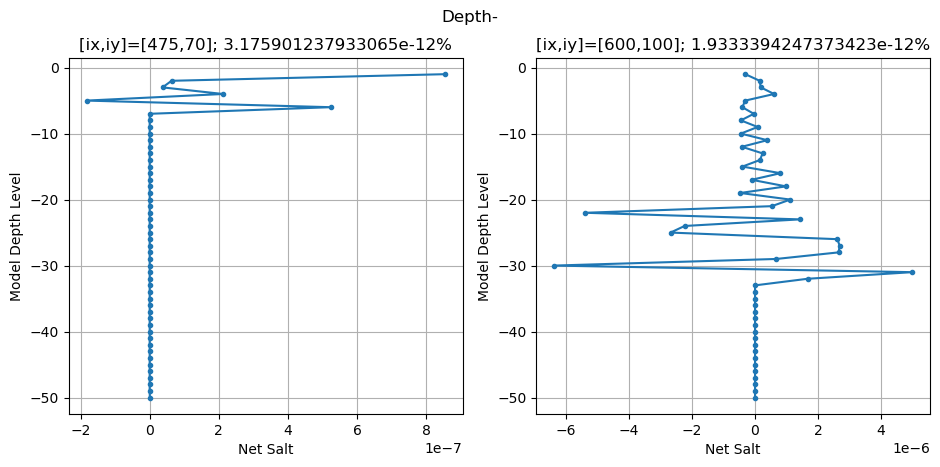

In [29]:
# Figure 1
plt.figure(1, figsize=(9.5, 8.5))
aa = np.zeros((nz, 4))
plt.suptitle("Depth-")

# four figures labeled n
for n in range(1, 3):
    ix, iy, k = pt[n-1]
    aa[:, n-1] = budgO['fluxes']['tend'][:, iy, ix] - budgO['fluxes']['zconv'][:, iy, ix] - budgO['fluxes']['hconv'][:, iy, ix]
    #aa[:, n-1] = budgO['tend'][iy, ix] - budgO['hconv'][0,iy, ix] - budgO['zconv'][iy, ix]

    plt.subplot(2, 2, n)
    plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
    plt.grid()
    #plt.xlabel(f"net budg{strbudg[0]}o")
    plt.xlabel("Net Salt")
    plt.ylabel("Model Depth Level")
    plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['fluxes']['zconv'][:,iy, ix]))}%")
        
plt.tight_layout()
plt.show()

In [32]:
# print the terms for the first point
y = 540
x = 50

print("salt tendency: ", budgO['fluxes']['tend'][0, y, x] , "g/s")
print()
print("zconv: ", budgO['fluxes']['zconv'][0, y, x])
print("hconv: ", budgO['fluxes']['hconv'][0, y, x])
print()
print("residual: ", budgO['fluxes']['tend'][0, y, x] - budgO['fluxes']['zconv'][0, y, x] - budgO['fluxes']['hconv'][0, y, x])

salt tendency:  51285.99253899379 g/s

zconv:  14950876.515649956
hconv:  -14899590.523111224

residual:  2.6263296604156494e-07


In [30]:
a = budgO['fluxes']['tend'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))
b = budgO['fluxes']['hconv'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))
c = budgO['fluxes']['zconv'] * np.tile(hfC1p[np.newaxis,:, :], (nz, 1, 1))

a[np.isnan(a)] = 0
b[np.isnan(b)] = 0
c[np.isnan(c)] = 0

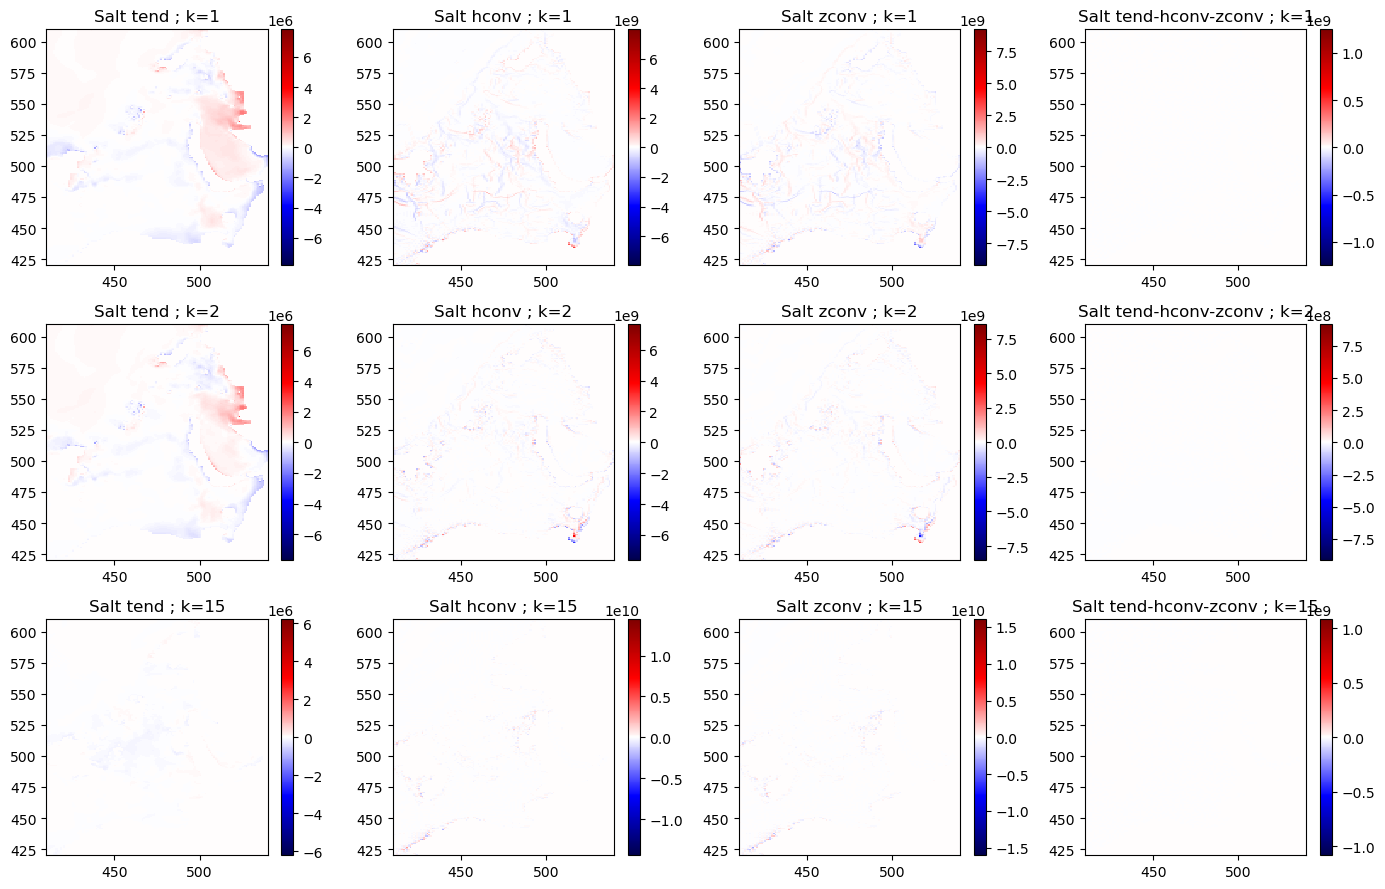

In [31]:
# Figure 2


klev = [1, 2, 15]
fig, axes = plt.subplots(3, 4, figsize=(14, 9))

for idx, k1 in enumerate(klev):
    str_k = f"; k={k1}"
    fourth = 1
    for j, (data, title) in enumerate([(a, 'tend'), (b, 'hconv'), (c, 'zconv'), (a-b-c, 'tend-hconv-zconv')]):
        ax = axes[idx, j]
        mydata = get_aste_tracer(data[k1-1,:, :],nfx,nfy)[0]
        # #mydata = data[k1-1,:, :]
        # if fourth == 4:
        #     pcm = ax.pcolormesh(mydata, cmap='seismic', vmin=-1e-4, vmax=1e-4)
        # else:
        pcm = ax.pcolormesh(mydata, cmap='seismic', vmin=-0.99*abs(data[k1-1,:, :].max()), vmax=0.99*abs(data[k1-1,:, :].max()))
        fig.colorbar(pcm, ax=ax)

        #ax.scatter(get_aste_tracer(np.array([[533],[56]]),nfx,nfy)[0])
    
        ax.set_title(f"{strbudg} {title} {str_k}")
        ax.set_xlim(410,540)
        ax.set_ylim(420,610)

        fourth += 1

plt.tight_layout()
# plt.savefig(f"{dirOut}{strbudg}_budget2_{t2:010}.png")
plt.show()

# do a single point comparison to prove that this is budgeted

In [32]:
# do the surface, bottom and one other point
x = pt[0][0]
y = pt[0][1]
z = 5    # also do 5, 18 (or 17)

In [33]:
# do the point breakdown
a = (budgO['fluxes']['tend'][z, y, x])
b = (budgO['fluxes']['zconv'][z, y, x])
c = (budgO['fluxes']['hconv'][z, y, x])
print(a-b-c)

5.234032869338989e-07


# great, this is budgeted, now we can move on to heat and try to create the vectors

In [34]:
# we have budgO['fluxes']['ADV_hconv'] and ...['DF_hconv'] which are the hconv components from each
# budgO['fluxes'][ADV_Tconv] and ...[DF_Tconv]
# budgO['fluxes']['KPP_Tconv']
# swtop
# if we look at the surface, we should have Ttend - ADV

# for the surface!!
x = pt[0][0]
y = pt[0][1]
z = 0    # also do 5, 18 (or 17)

print(z,y,x)
print()

# do a tester cell
ctend = budgO['fluxes']['tend'][z,y,x]               # g/s
cadvtconv = budgO['fluxes']['ADV_Sconv'][z,y,x]      # g/s
cdftconv = budgO['fluxes']['DF_Sconv'][z,y,x]        # g/s
ckppconv = budgO['fluxes']['KPP_Sconv'][z,y,x]       # g/s  
czconv = zconv_top[y,x]
# cswtop = swtop[z+1,y,x]

print(ctend)
print(cadvtconv)
print(cdftconv)
print(czconv)
print(ckppconv)
# print(cswtop)
print()

vectorconv = ctend - cadvtconv - cdftconv - ckppconv - czconv
print(vectorconv)

0 475 70

340760.23183245654
-86620.27004839852
539799.5719098279
-10350.644103391076
0.0

-102068.42592558173


In [35]:
# we have budgO['fluxes']['ADV_hconv'] and ...['DF_hconv'] which are the hconv components from each
# budgO['fluxes'][ADV_Tconv] and ...[DF_Tconv]
# budgO['fluxes']['KPP_Tconv']
# swtop
# if we look at the surface, we should have Ttend - ADV

# for the surface!!
x = pt[0][0]
y = pt[0][1]
z = 6    # also do 5, 18 (or 17)

print(z,y,x)
print()

# do a tester cell
ctend = budgO['fluxes']['tend'][z,y,x]               # g/s
cadvtconv = budgO['fluxes']['ADV_Sconv'][z,y,x]      # g/s
cdftconv = budgO['fluxes']['DF_Sconv'][z,y,x]        # g/s
ckppconv = budgO['fluxes']['KPP_Sconv'][z,y,x]       # g/s  
czconv = zconv_top[y,x]

print(ctend)
print(cadvtconv)
print(cdftconv)
print(czconv)
print(ckppconv)
# print(cswtop)
print()

vectorconv = ctend - cadvtconv - cdftconv - ckppconv
print(vectorconv)

6 475 70

0.0
0.0
0.0
-10350.644103391076
0.0

0.0


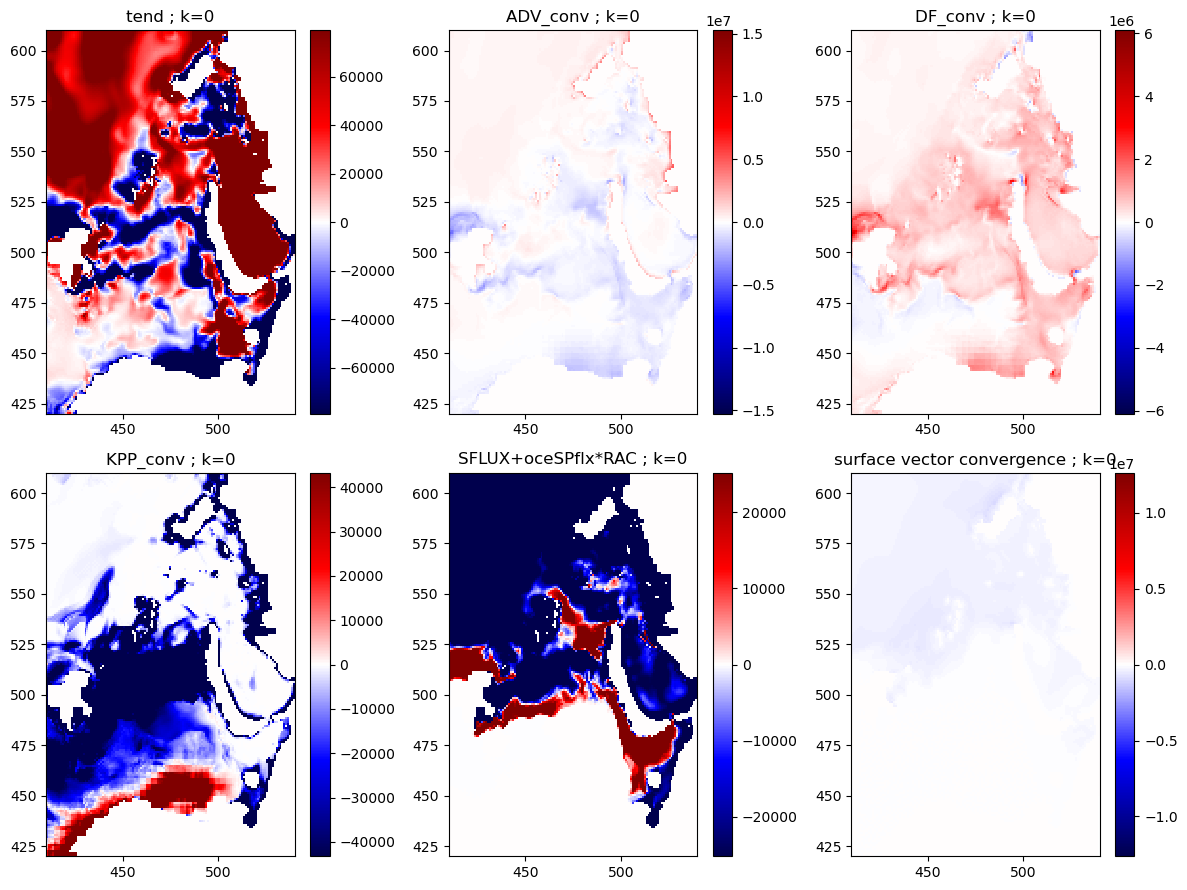

In [41]:
# Data variables (as given in your initial code)
a = budgO['fluxes']['tend']
b = budgO['fluxes']['ADV_Sconv']
c = budgO['fluxes']['DF_Sconv']
d = budgO['fluxes']['KPP_Sconv']
e = zconv_top.reshape(1,ny,nx)                 # NOTE - this is only at the surface
f = tmp1    # from the oceSPflx and oceSPtnd

fig, axes = plt.subplots(2, 3, figsize=(12, 9))

k1 = 0
str_k = f"; k={k1}"

# Data and titles for the plots
plot_data = [
    (a, 'tend'), 
    (b, 'ADV_conv'), 
    (c, 'DF_conv'), 
    (d, 'KPP_conv'), 
    (e, 'SFLUX+oceSPflx*RAC'), 
    (a-b-c-d-e, 'surface vector convergence')
]

# Loop through the data and plot in the respective axes
for idx, (data, title) in enumerate(plot_data):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    mydata = get_aste_tracer(data[k1,:, :], nfx, nfy)[0]
    
    pcm = ax.pcolormesh(mydata, cmap='seismic', vmin=-1e-2 * abs(np.nanmax(data[k1,:, :])), vmax=1e-2 * abs(np.nanmax(data[k1,:, :])))
    fig.colorbar(pcm, ax=ax)

    ax.set_title(f"{title} {str_k}")
    ax.set_xlim(410, 540)
    ax.set_ylim(420, 610)

plt.tight_layout()
plt.show()

In [43]:
# check on another point at T_f
file_name = "state_3d_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])

theta = THETA.reshape(nz,ny,nx)
salt = SALT.reshape(nz,ny,nx)
theta[theta == 0] = np.nan
salt[salt == 0] = np.nan

Text(0.5, 1.0, 'salt')

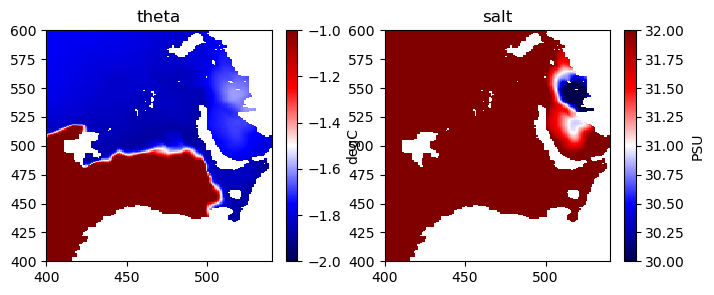

In [44]:
# first tendency in salt and theta
fig = plt.figure(figsize=(8,3))

ax = plt.subplot(121)
cb = ax.pcolormesh(get_aste_tracer(theta,nfx,nfy)[0],cmap='seismic',vmin=-2,vmax=-1)
plt.colorbar(cb, label = "degC")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("theta")

ax = plt.subplot(122)
cb = ax.pcolormesh(get_aste_tracer(salt,nfx,nfy)[0],cmap='seismic',vmin=30,vmax=32)
plt.colorbar(cb,label = "PSU")
ax.set_xlim(400,540)
ax.set_ylim(400,600)
ax.set_title("salt")

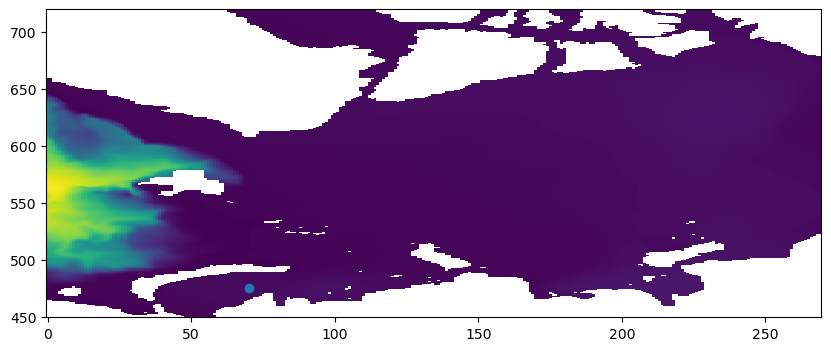

In [45]:
# pick another point
# plot for face 3
XV,YV = np.meshgrid(np.arange(0,270,1),np.arange(450,720,1))
plt.pcolormesh(XV,YV,theta[0][450:720,:270])
y = 475
x = 70
plt.plot(x,y,'o')

In [51]:
# pick one point from face 3 and one point from face 1
pt = np.array([[10,500,4],       # this is organized as x,y,z
               [220,445,10]])

# pick one point from face 3 and one point from face 1
pt = np.array([[70,525,4],       # this is organized as x,y,z
               [220,445,10]])

In [55]:
f[:,525,70]

array([2.49173891e+05, 2.49173719e+05, 2.49172552e+05, 2.49168231e+05,
       2.49156607e+05, 2.49130875e+05, 2.49080911e+05, 2.48992494e+05,
       2.48846480e+05, 2.48616483e+05, 2.48263680e+05, 2.47722822e+05,
       2.46868898e+05, 2.45446809e+05, 2.42906952e+05, 2.38031590e+05,
       2.28065650e+05, 2.06694501e+05, 1.59469965e+05, 5.41243133e+04,
       8.69297246e-10, 8.69297246e-10, 8.69297246e-10, 8.69297246e-10,
       8.69297246e-10, 8.69297246e-10, 8.69297246e-10, 8.69297246e-10,
       8.69297246e-10, 8.69297246e-10, 8.69297246e-10, 8.69297246e-10,
       8.69297246e-10, 8.69297246e-10, 8.69297246e-10, 8.69297246e-10,
       8.69297246e-10, 8.69297246e-10, 8.69297246e-10, 8.69297246e-10,
       8.69297246e-10, 8.69297246e-10, 8.69297246e-10, 8.69297246e-10,
       8.69297246e-10, 8.69297246e-10, 8.69297246e-10, 8.69297246e-10,
       8.69297246e-10, 8.69297246e-10])

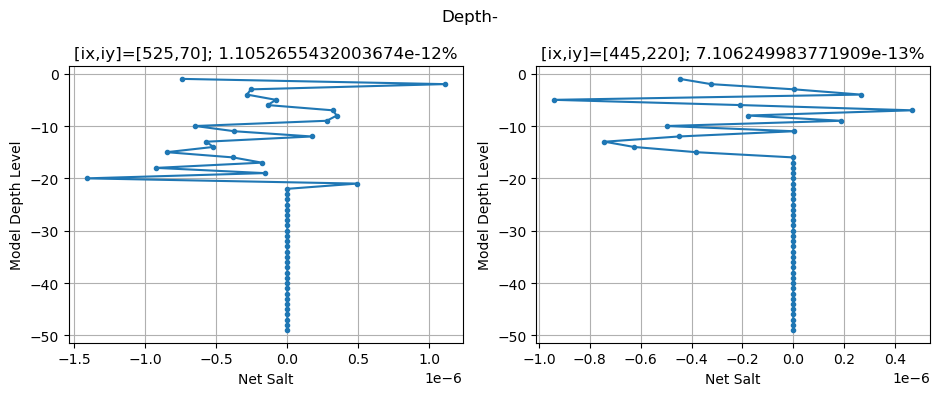

In [58]:
# also show the convergence at depth - I will make this a 1 by 2 plot so I can look at things easier

plt.figure(figsize=(9.5, 4))

aa = np.zeros((nz, 2))
plt.suptitle("Depth-")


n = 1
ix, iy, k = pt[n-1]
aa[:, n-1] = a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix]
aa[1:, n-1] += (f[1:,iy,ix] - f[:-1,iy,ix])      # from the tmp from 
aa[0, n-1] += f[0,iy,ix]
aa[0, n-1] -= zconv_top[iy, ix]
plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Salt")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['fluxes']['zconv'][:,iy, ix]))}%")

n = 2
ix, iy, k = pt[n-1]
aa[:, n-1] = a[:, iy, ix] - b[:, iy, ix] - c[:, iy, ix] - d[:, iy, ix]
aa[0, n-1] -= zconv_top[iy, ix]

plt.subplot(1, 2, n)
plt.plot(aa[:, n-1], -np.arange(1, nz+1), '.-')
plt.grid()
plt.xlabel("Net Salt")
plt.ylabel("Model Depth Level")
plt.title(f"[ix,iy]=[{iy},{ix}]; {100 * np.nanmax(np.abs(aa[:, n-1]))/np.nanmax(np.abs(budgO['fluxes']['zconv'][:,iy, ix]))}%")
    
        
plt.tight_layout()
plt.show()